In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

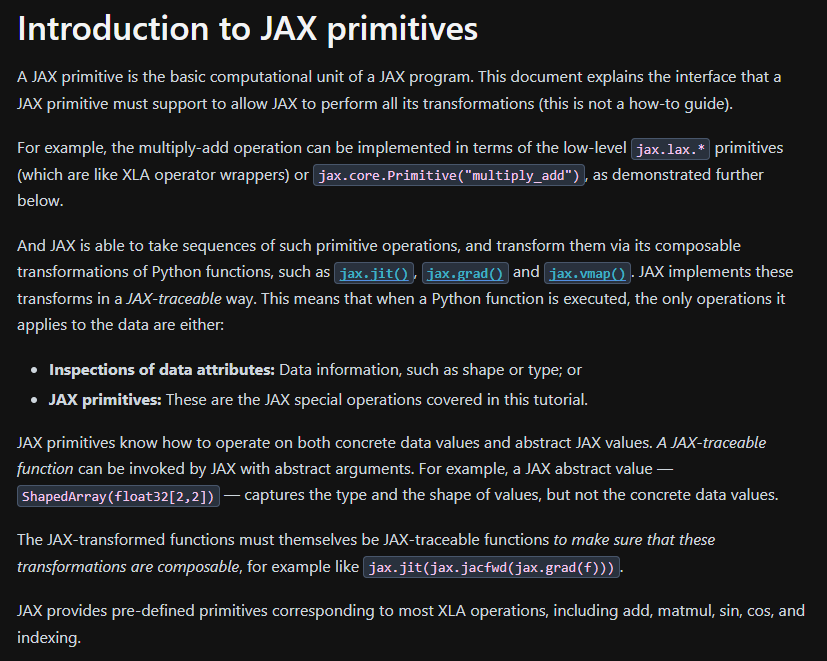

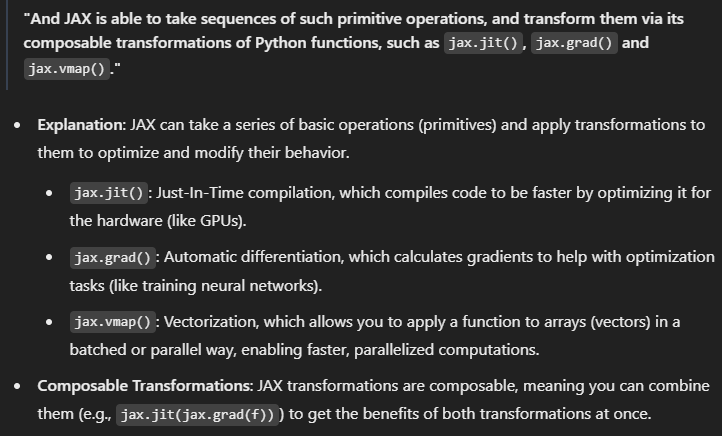

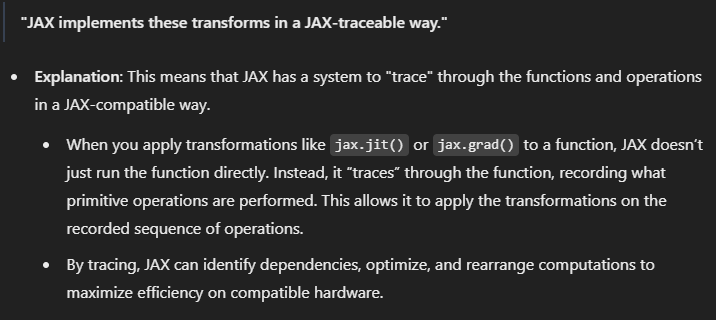

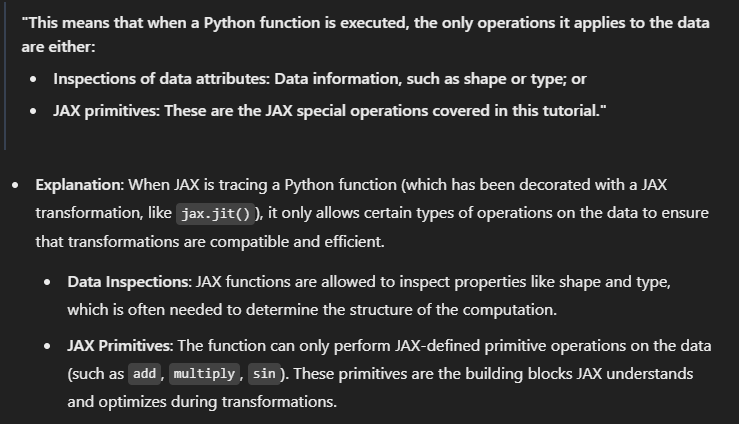

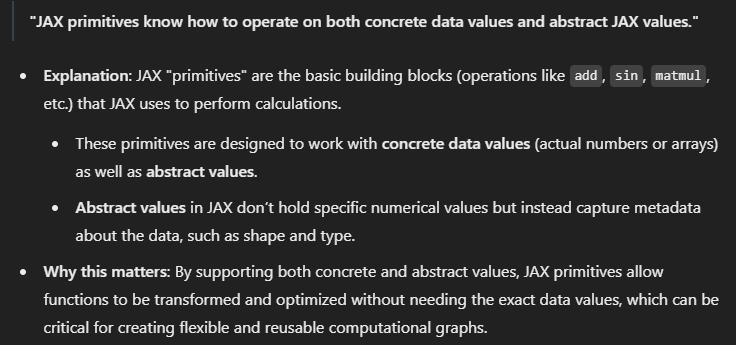

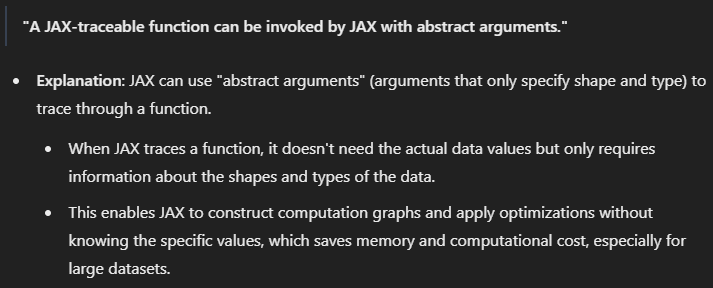

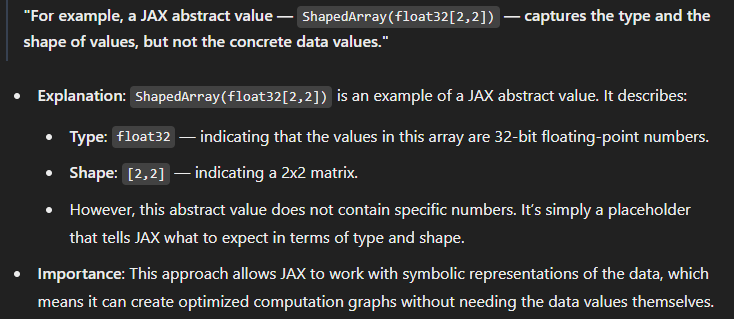

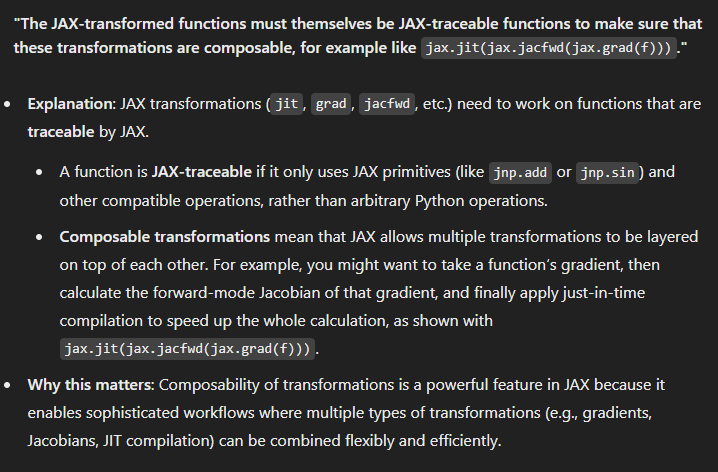

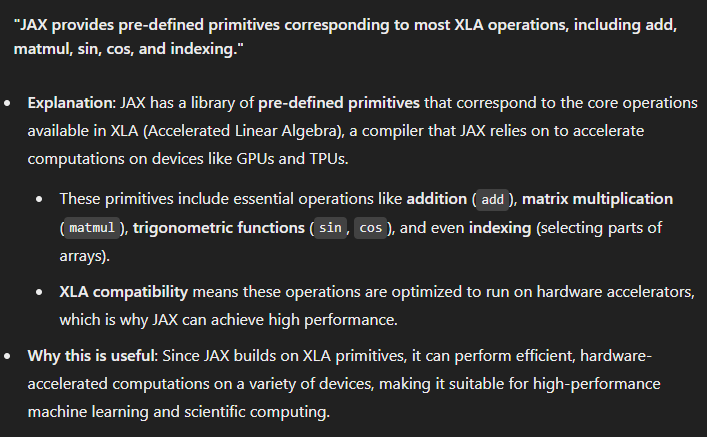

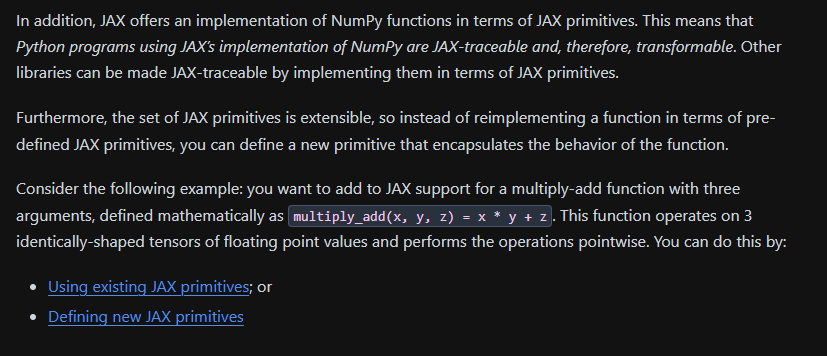

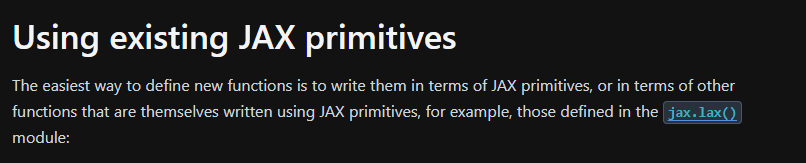

In [2]:
from jax import lax
from jax._src import api

def multiply_add_lax(x, y, z):
  """Implementation of multiply-add using the `jax.lax` primitives."""
  return lax.add(lax.mul(x, y), z)


def square_add_lax(a, b):
  """A square-add function using the newly defined multiply-add."""
  return multiply_add_lax(a, a, b)

print("square_add_lax = ", square_add_lax(2., 10.))
# Differentiate w.r.t. the first argument
print("grad(square_add_lax) = ", api.grad(square_add_lax, argnums=0)(2.0, 10.))

square_add_lax =  14.0
grad(square_add_lax) =  4.0


In [3]:
#@title Helper functions (execute this cell)
import functools
import traceback

_indentation = 0
def _trace(msg=None):
    """Print a message at current indentation."""
    if msg is not None:
        print("  " * _indentation + msg)

def _trace_indent(msg=None):
    """Print a message and then indent the rest."""
    global _indentation
    _trace(msg)
    _indentation = 1 + _indentation

def _trace_unindent(msg=None):
    """Unindent then print a message."""
    global _indentation
    _indentation = _indentation - 1
    _trace(msg)

def trace(name):
  """A decorator for functions to trace arguments and results."""

  def trace_func(func):  # pylint: disable=missing-docstring
    def pp(v):
        """Print certain values more succinctly"""
        vtype = str(type(v))
        if "jax._src.xla_bridge._JaxComputationBuilder" in vtype:
            return "<JaxComputationBuilder>"
        elif "jaxlib.xla_extension.XlaOp" in vtype:
            return "<XlaOp at 0x{:x}>".format(id(v))
        elif ("partial_eval.JaxprTracer" in vtype or
              "batching.BatchTracer" in vtype or
              "ad.JVPTracer" in vtype):
            return "Traced<{}>".format(v.aval)
        elif isinstance(v, tuple):
            return "({})".format(pp_values(v))
        else:
            return str(v)
    def pp_values(args):
        return ", ".join([pp(arg) for arg in args])
    
    @functools.wraps(func)
    def func_wrapper(*args):
      _trace_indent("call {}({})".format(name, pp_values(args)))
      res = func(*args)
      _trace_unindent("|<- {} = {}".format(name, pp(res)))
      return res

    return func_wrapper

  return trace_func

class expectNotImplementedError(object):
  """Context manager to check for NotImplementedError."""
  def __enter__(self): pass
  def __exit__(self, type, value, tb):
    global _indentation
    _indentation = 0
    if type is NotImplementedError:
      print("\nFound expected exception:")
      traceback.print_exc(limit=3)
      return True
    elif type is None:  # No exception
      assert False, "Expected NotImplementedError"
    else:
      return False

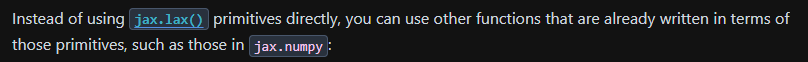

In [4]:
import jax.numpy as jnp
import numpy as np

@trace("multiply_add_numpy")
def multiply_add_numpy(x, y, z):
    return jnp.add(jnp.multiply(x, y), z)

@trace("square_add_numpy")
def square_add_numpy(a, b):
    return multiply_add_numpy(a, a, b)

print("\nNormal evaluation:")  
print("square_add_numpy = ", square_add_numpy(2., 10.))
print("\nGradient evaluation:")
print("grad(square_add_numpy) = ", api.grad(square_add_numpy)(2.0, 10.))


Normal evaluation:
call square_add_numpy(2.0, 10.0)
  call multiply_add_numpy(2.0, 2.0, 10.0)
  |<- multiply_add_numpy = 14.0
|<- square_add_numpy = 14.0
square_add_numpy =  14.0

Gradient evaluation:
call square_add_numpy(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
  call multiply_add_numpy(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
  |<- multiply_add_numpy = Traced<ConcreteArray(14.0, dtype=float32, weak_type=True)>
|<- square_add_numpy = Traced<ConcreteArray(14.0, dtype=float32, weak_type=True)>
grad(square_add_numpy) =  4.0


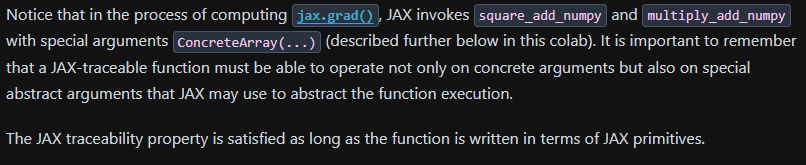

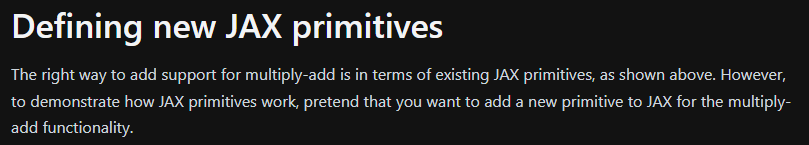

In [5]:
from jax import core

multiply_add_p = core.Primitive("multiply_add")  # Create the primitive

@trace("multiply_add_prim")
def multiply_add_prim(x, y, z):
  """The JAX-traceable way to use the JAX primitive.
  
  Note that the traced arguments must be passed as positional arguments
  to `bind`. 
  """
  return multiply_add_p.bind(x, y, z)

@trace("square_add_prim")
def square_add_prim(a, b):
  """A square-add function implemented using the new JAX-primitive."""
  return multiply_add_prim(a, a, b)

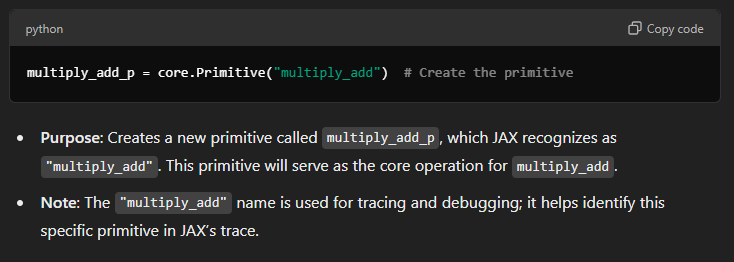

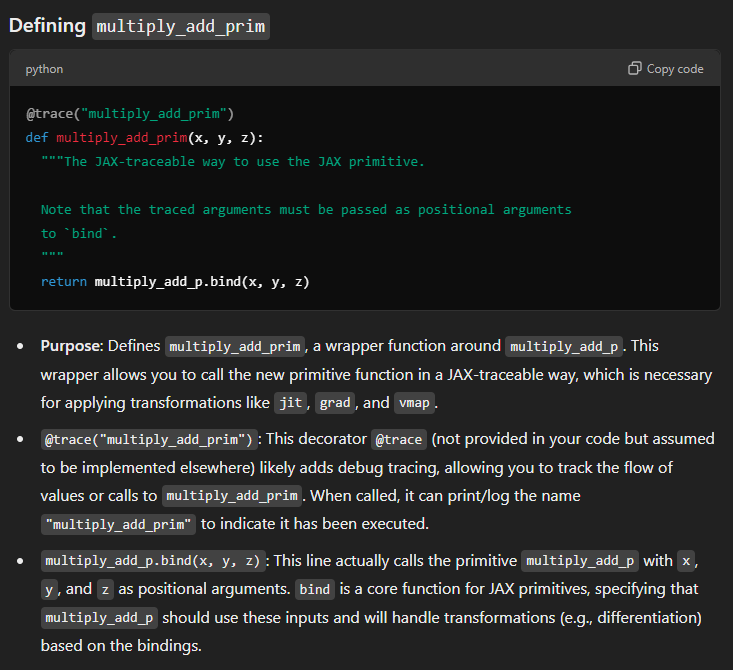

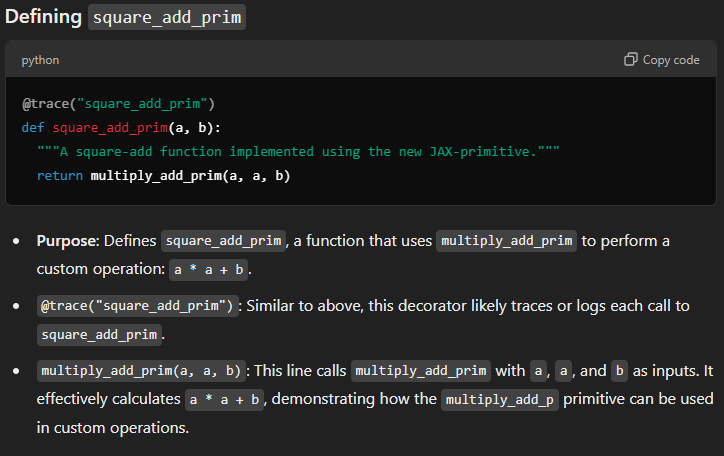

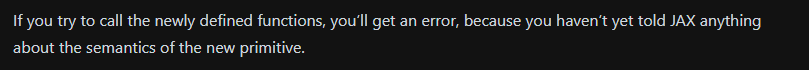

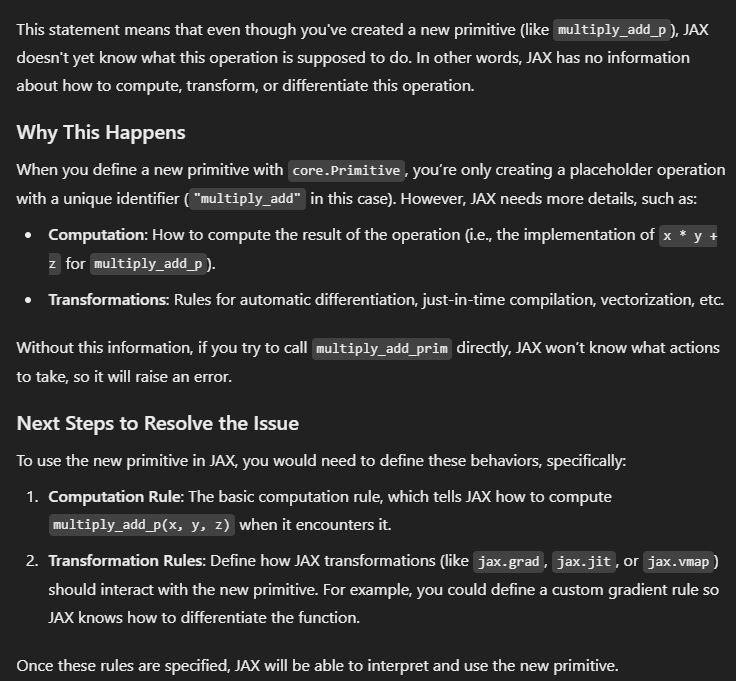

In [6]:
with expectNotImplementedError():
  square_add_prim(2., 10.)

call square_add_prim(2.0, 10.0)
  call multiply_add_prim(2.0, 2.0, 10.0)

Found expected exception:


Traceback (most recent call last):
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\2844449444.py", line 2, in <module>
    square_add_prim(2., 10.)
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\1393342955.py", line 48, in func_wrapper
    res = func(*args)
          ^^^^^^^^^^^
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\1751132419.py", line 17, in square_add_prim
    return multiply_add_prim(a, a, b)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
NotImplementedError: Evaluation rule for 'multiply_add' not implemented


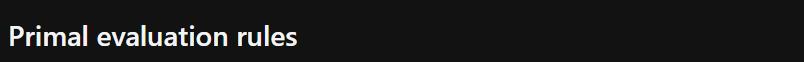

In [7]:
@trace("multiply_add_impl")
def multiply_add_impl(x, y, z):
  """Concrete implementation of the primitive.

  This function does not need to be JAX traceable.

  Args:
    x, y, z: The concrete arguments of the primitive. Will only be called with 
      concrete values.

  Returns:
    the concrete result of the primitive.
  """
  # Note: you can use the ordinary (non-JAX) NumPy, which is not JAX-traceable.
  return np.add(np.multiply(x, y), z)

# Now, register the primal implementation with JAX:
multiply_add_p.def_impl(multiply_add_impl)

<function __main__.multiply_add_impl(x, y, z)>

In [8]:
assert square_add_prim(2., 10.) == 14.

call square_add_prim(2.0, 10.0)
  call multiply_add_prim(2.0, 2.0, 10.0)
    call multiply_add_impl(2.0, 2.0, 10.0)
    |<- multiply_add_impl = 14.0
  |<- multiply_add_prim = 14.0
|<- square_add_prim = 14.0


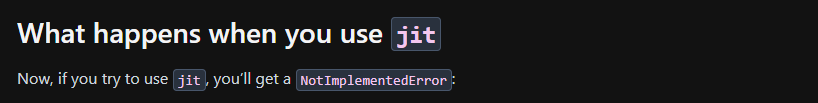

In [9]:
with expectNotImplementedError():
  api.jit(square_add_prim)(2., 10.)

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)

Found expected exception:


Traceback (most recent call last):
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\1813425700.py", line 2, in <module>
    api.jit(square_add_prim)(2., 10.)
  File "d:\anaconda3\Lib\site-packages\jax\_src\traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\Lib\site-packages\jax\_src\pjit.py", line 327, in cache_miss
    outs, out_flat, out_tree, args_flat, jaxpr, attrs_tracked = _python_pjit_helper(
                                                                ^^^^^^^^^^^^^^^^^^^^
NotImplementedError: Abstract evaluation for 'multiply_add' not implemented


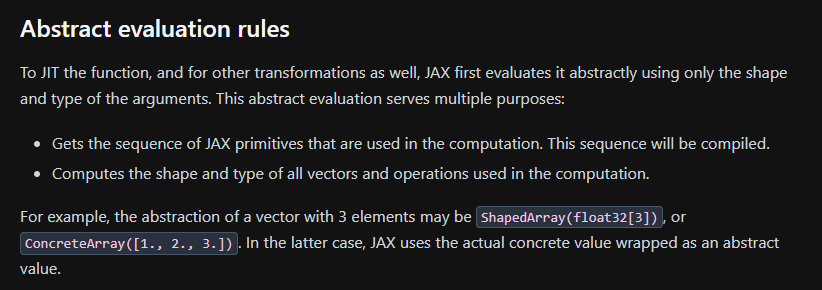

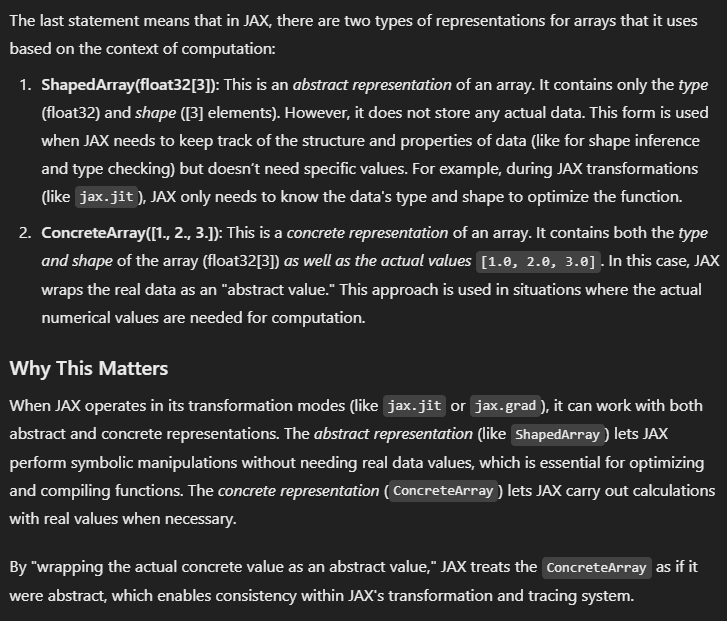

In [10]:
from jax import core

@trace("multiply_add_abstract_eval")
def multiply_add_abstract_eval(xs, ys, zs):
  """Abstract evaluation of the primitive.

  This function does not need to be JAX traceable. It will be invoked with
  abstractions of the actual arguments

  Args:
    xs, ys, zs: Abstractions of the arguments.

  Result:
    a ShapedArray for the result of the primitive.
  """
  assert xs.shape == ys.shape
  assert xs.shape == zs.shape
  return core.ShapedArray(xs.shape, xs.dtype)

# Now, register the abstract evaluation with JAX:
multiply_add_p.def_abstract_eval(multiply_add_abstract_eval)

<function __main__.multiply_add_abstract_eval(xs, ys, zs)>

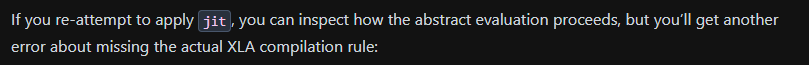

In [11]:
with expectNotImplementedError():
  api.jit(square_add_prim)(2., 10.)

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
    call multiply_add_abstract_eval(ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True))
    |<- multiply_add_abstract_eval = ShapedArray(float32[])
  |<- multiply_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
|<- square_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>

Found expected exception:


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\haadi\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
jax._src.source_info_util.JaxStackTraceBeforeTransformation: NotImplementedError: MLIR translation rule for primitive 'multiply_add' not found for platform cpu

The preceding stack trace is the source of the JAX operation that, once transformed by JAX, triggered the following exception.

--------------------

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\1813425700.py", line 2, in <module>
    api.jit(square_add_prim)(2., 10.)
  File "d:\anaconda3\Lib\site-packages\jax\_src\traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
           ^^^^^^^^^^^

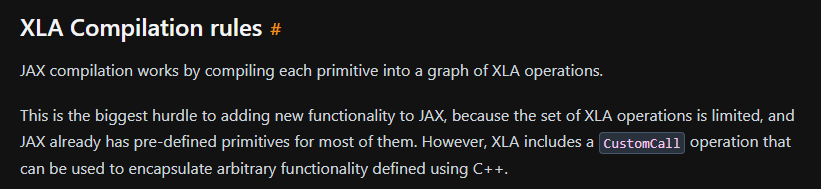

In [12]:
from jax._src.lib.mlir.dialects import hlo

@trace("multiply_add_lowering")
def multiply_add_lowering(ctx, xc, yc, zc):
  """The compilation to XLA of the primitive.

  Given an mlir.ir.Value for each argument, return the mlir.ir.Values for
  the results of the function.

  Does not need to be a JAX-traceable function.
  """
  return [hlo.AddOp(hlo.MulOp(xc, yc), zc).result]

# Now, register the lowering rule with JAX.
# For GPU, refer to the https://jax.readthedocs.io/en/latest/Custom_Operation_for_GPUs.html
from jax.interpreters import mlir

mlir.register_lowering(multiply_add_p, multiply_add_lowering, platform='cpu')

<function __main__.multiply_add_lowering(ctx, xc, yc, zc)>

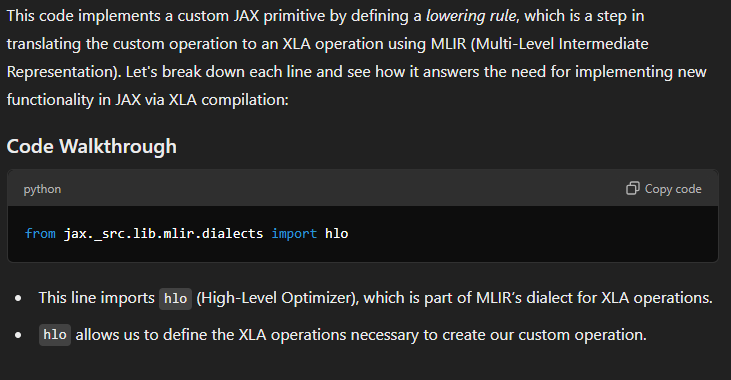

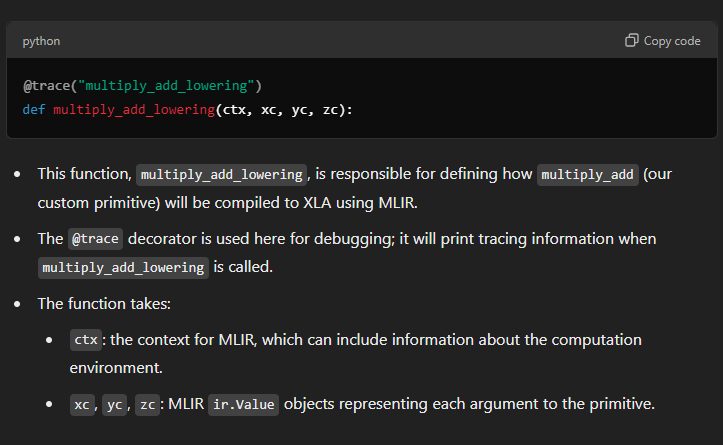

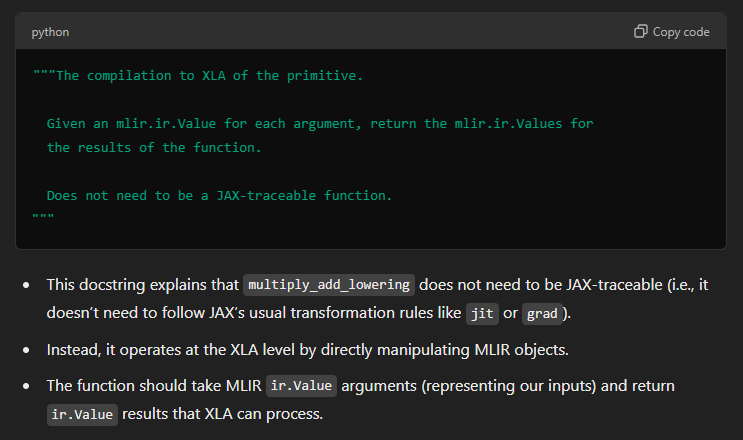

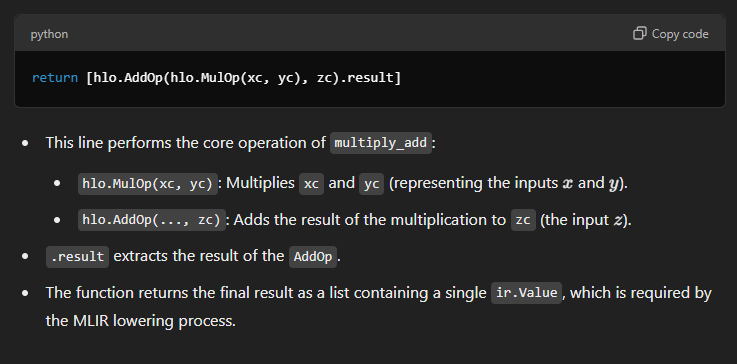

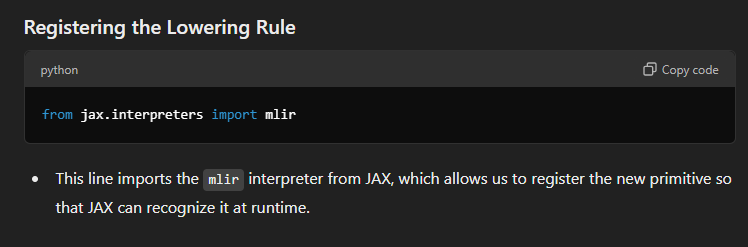

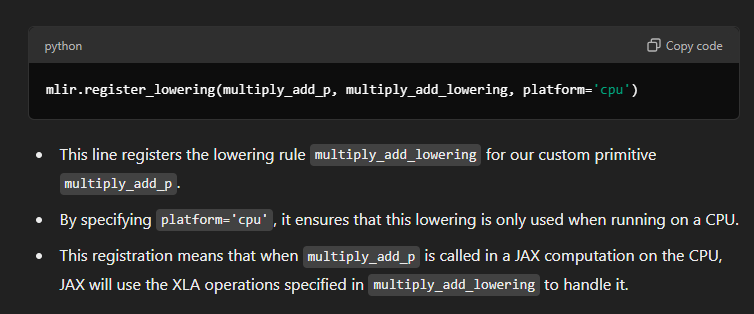

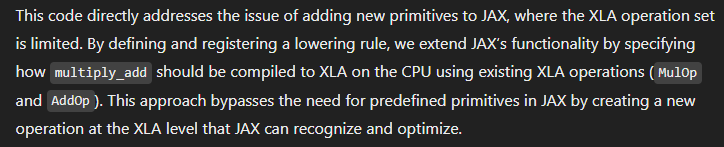

In [13]:
assert api.jit(lambda x, y: square_add_prim(x, y))(2., 10.) == 14.

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
    call multiply_add_abstract_eval(ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True))
    |<- multiply_add_abstract_eval = ShapedArray(float32[])
  |<- multiply_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
|<- square_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
call multiply_add_lowering(LoweringRuleContext(module_context=ModuleContext(context=<jaxlib.mlir._mlir_libs._site_initialize.<locals>.Context object a

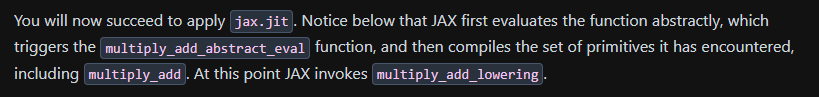

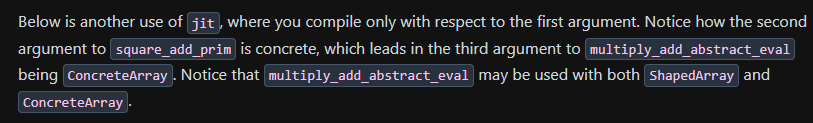

In [14]:
assert api.jit(lambda x, y: square_add_prim(x, y), 
               static_argnums=1)(2., 10.) == 14.

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, 10.0)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, 10.0)
    call multiply_add_abstract_eval(ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True))
    |<- multiply_add_abstract_eval = ShapedArray(float32[])
  |<- multiply_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
|<- square_add_prim = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
call multiply_add_lowering(LoweringRuleContext(module_context=ModuleContext(context=<jaxlib.mlir._mlir_libs._site_initialize.<locals>.Context object at 0x000001F0B8796B70>, module=<jaxlib.mlir._mlir_libs._mlir.ir.Module object at 0x000001F0B87C9AB0>, ip=<jaxlib.mlir._mlir_libs._mlir.ir.InsertionPoint 

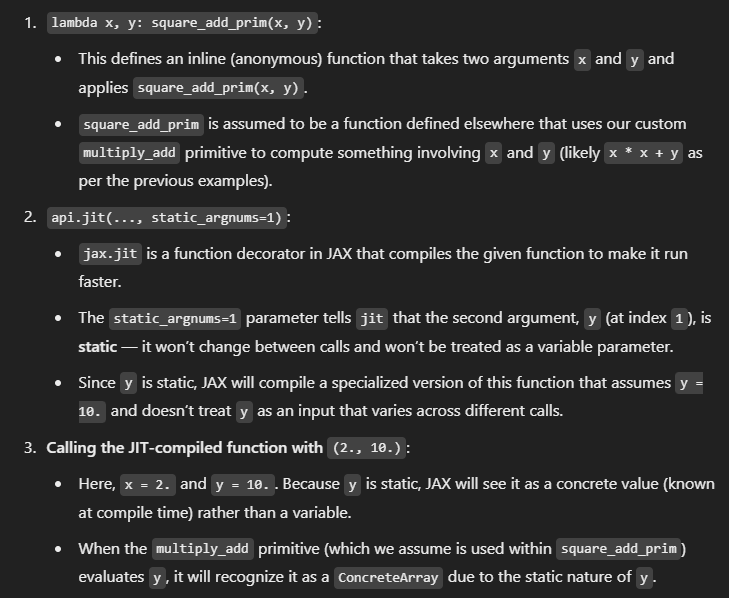

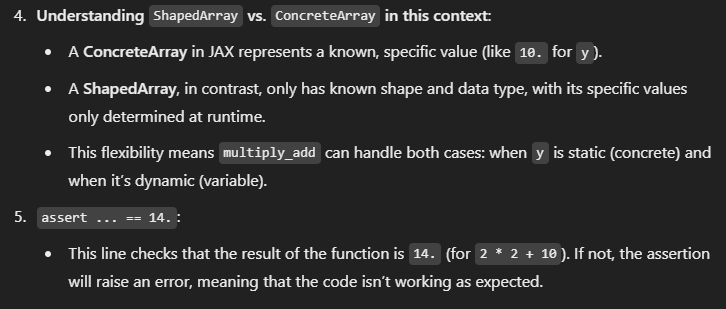

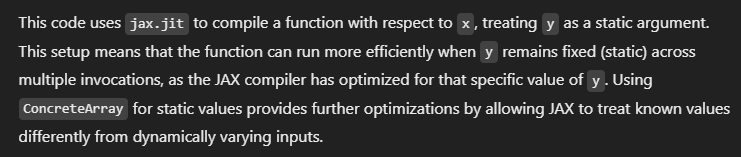

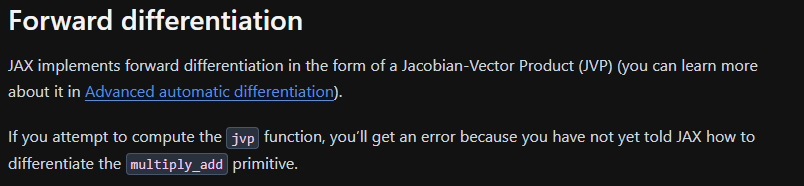

In [15]:
# The second argument is set to `(2., 10.)` values where you
# evaluate the Jacobian, and the third argument `(1., 1.)`
# contains the values of the tangents for the arguments.
with expectNotImplementedError():
  api.jvp(square_add_prim, (2., 10.), (1., 1.))

call square_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(10.0, dtype=float32, weak_type=True)>)
  call multiply_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(10.0, dtype=float32, weak_type=True)>)

Found expected exception:


Traceback (most recent call last):
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\459539105.py", line 5, in <module>
    api.jvp(square_add_prim, (2., 10.), (1., 1.))
  File "d:\anaconda3\Lib\site-packages\jax\_src\api.py", line 1901, in jvp
    return _jvp(lu.wrap_init(fun), primals, tangents, has_aux=has_aux)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\Lib\site-packages\jax\_src\api.py", line 1930, in _jvp
    out_primals, out_tangents = ad.jvp(flat_fun).call_wrapped(ps_flat, ts_flat)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NotImplementedError: Differentiation rule for 'multiply_add' not implemented


In [16]:
from jax.interpreters import ad

@trace("multiply_add_value_and_jvp")
def multiply_add_value_and_jvp(arg_values, arg_tangents):
  """Evaluates the primal output and the tangents (Jacobian-vector product).

  Given values of the arguments and perturbation of the arguments (tangents), 
  compute the output of the primitive and the perturbation of the output.

  This method must be JAX-traceable. JAX may invoke it with abstract values 
  for the arguments and tangents.

  Args:
    arg_values: A tuple of arguments
    arg_tangents: A tuple with the tangents of the arguments. The tuple has 
      the same length as the arg_values. Some of the tangents may also be the 
      special value `ad.Zero` to specify a zero tangent

  Returns:
     A pair of the primal output and the tangent.
  """
  x, y, z = arg_values
  xt, yt, zt = arg_tangents
  _trace("Primal evaluation:")
  # Now, you have a JAX-traceable computation of the output. 
  # Normally, you can use the multiply add (`ma`) primitive itself to compute the primal output. 
  primal_out = multiply_add_prim(x, y, z)

  _trace("Tangent evaluation:")
  # You must use a JAX-traceable way to compute the tangent. It turns out that 
  # the output tangent can be computed as (xt * y + x * yt + zt),
  # which you can implement in a JAX-traceable way using the same "multiply_add_prim" primitive.

  # You do need to deal specially with `Zero`. Here, you just turn it into a 
  # proper tensor of 0s (of the same shape as 'x'). 
  # An alternative would be to check for `Zero` and perform algebraic 
  # simplification of the output tangent computation.
  def make_zero(tan):
    return lax.zeros_like_array(x) if type(tan) is ad.Zero else tan  

  output_tangent = multiply_add_prim(make_zero(xt), y, multiply_add_prim(x, make_zero(yt), make_zero(zt)))
  return (primal_out, output_tangent)

# Register the forward differentiation rule with JAX:
ad.primitive_jvps[multiply_add_p] = multiply_add_value_and_jvp

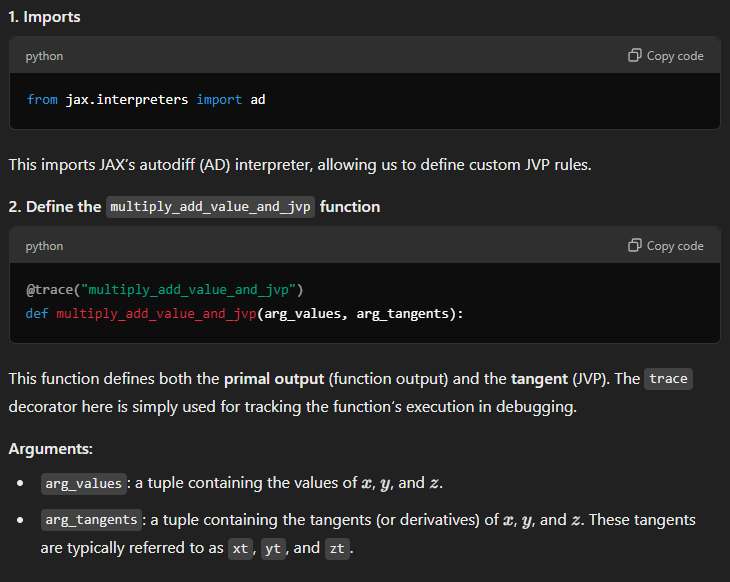

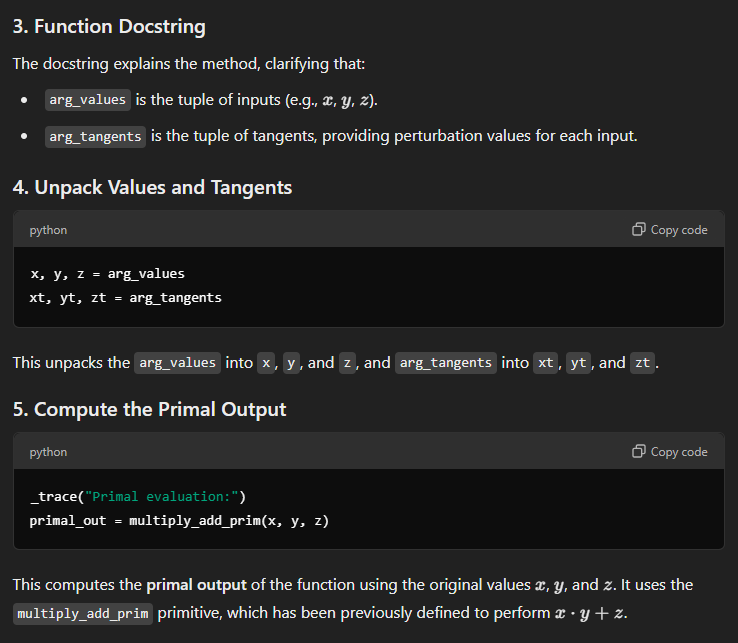

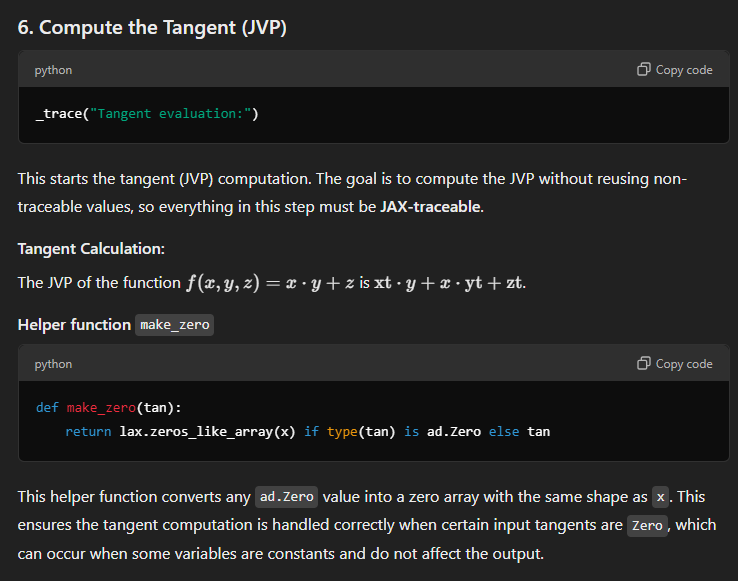

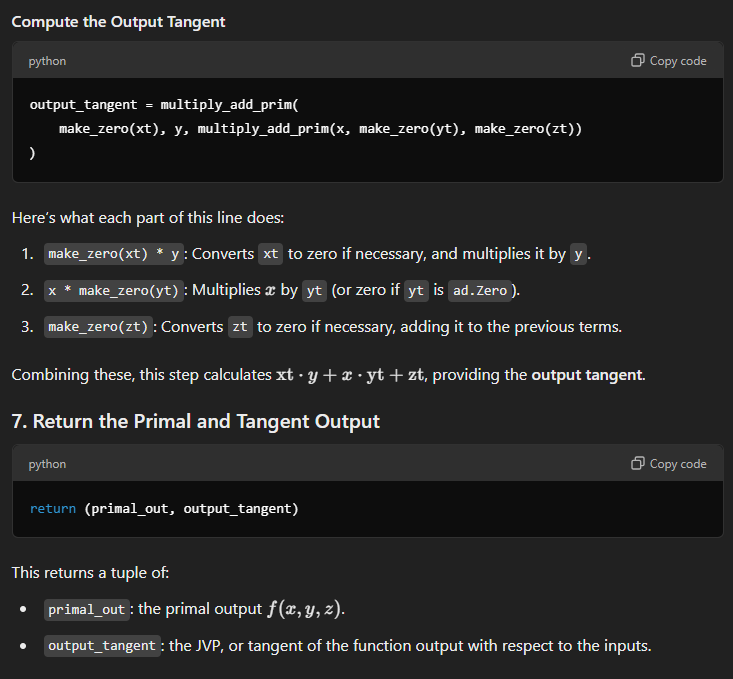

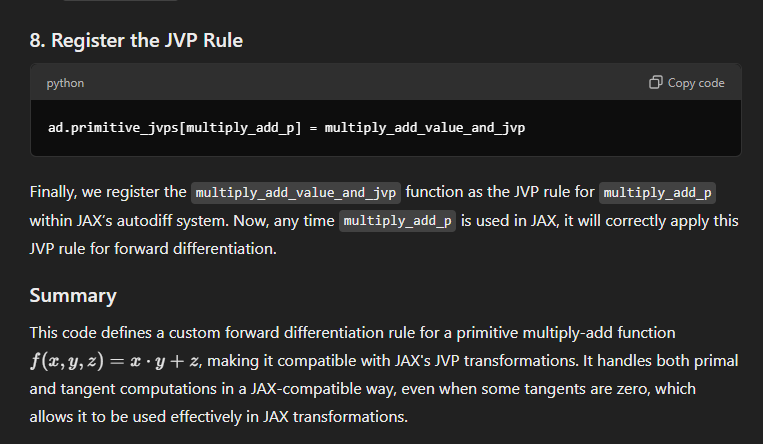

In [17]:
# Tangent is: xt*y + x*yt + zt = 1.*2. + 2.*1. + 1. = 5.
assert api.jvp(square_add_prim, (2., 10.), (1., 1.)) == (14., 5.)

call square_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(10.0, dtype=float32, weak_type=True)>)
  call multiply_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(10.0, dtype=float32, weak_type=True)>)
    call multiply_add_value_and_jvp((2.0, 2.0, 10.0), (1.0, 1.0, 1.0))
      Primal evaluation:
      call multiply_add_prim(2.0, 2.0, 10.0)
        call multiply_add_impl(2.0, 2.0, 10.0)
        |<- multiply_add_impl = 14.0
      |<- multiply_add_prim = 14.0
      Tangent evaluation:
      call multiply_add_prim(2.0, 1.0, 1.0)
        call multiply_add_impl(2.0, 1.0, 1.0)
        |<- multiply_add_impl = 3.0
      |<- multiply_add_prim = 3.0
      call multiply_add_prim(1.0, 2.0, 3.0)
        call multiply_add_impl(1.0, 2.0, 3.0)
        |<- multiply_add_impl = 5.0
      |<- multiply_add_prim = 5.0
    |<- multiply_add_value_and_jvp = (14.0, 5.0)
  

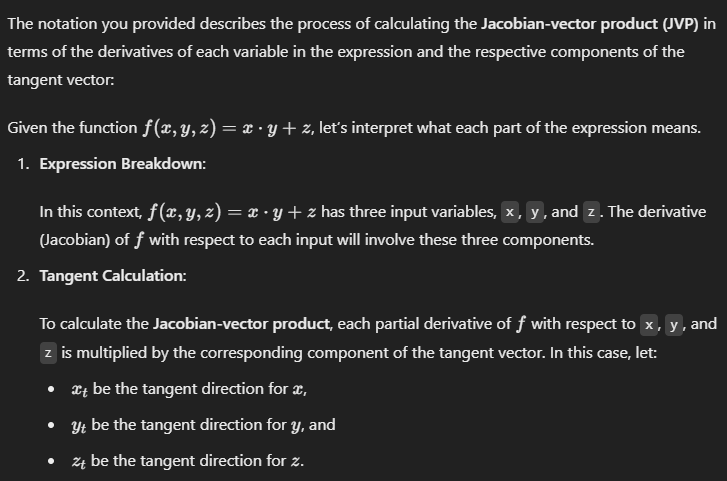

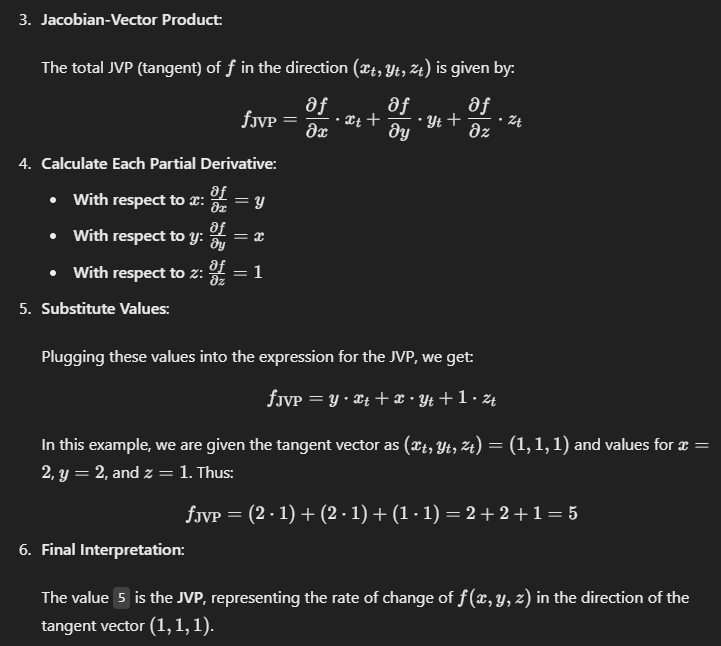

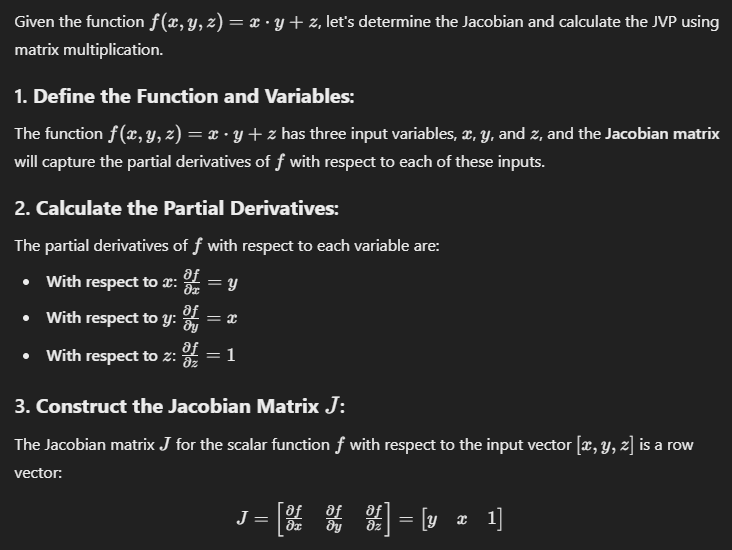

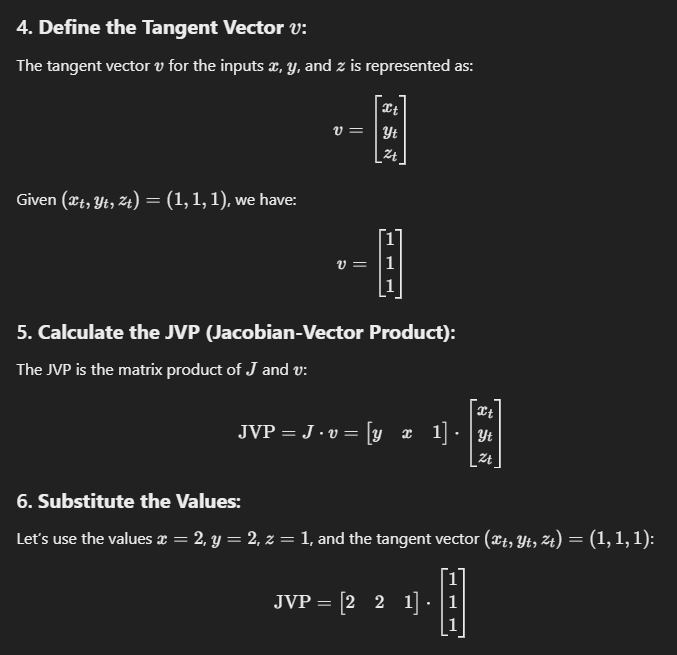

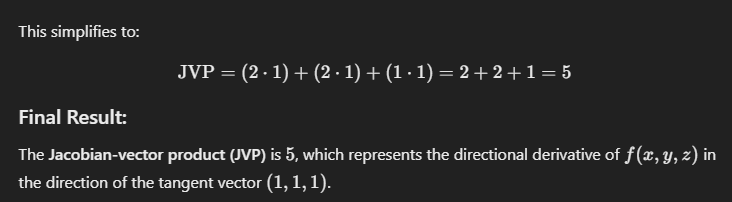

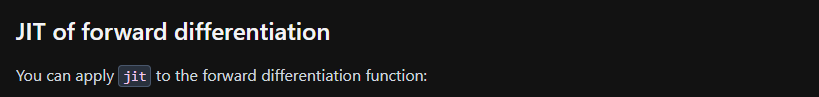

In [18]:
assert api.jit(lambda arg_values, arg_tangents: 
                   api.jvp(square_add_prim, arg_values, arg_tangents))(
         (2., 10.), (1., 1.)) == (14., 5.)

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>)
    call multiply_add_value_and_jvp((Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>), (Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>))
      Primal evaluation:
      call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>

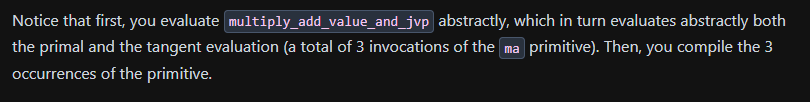

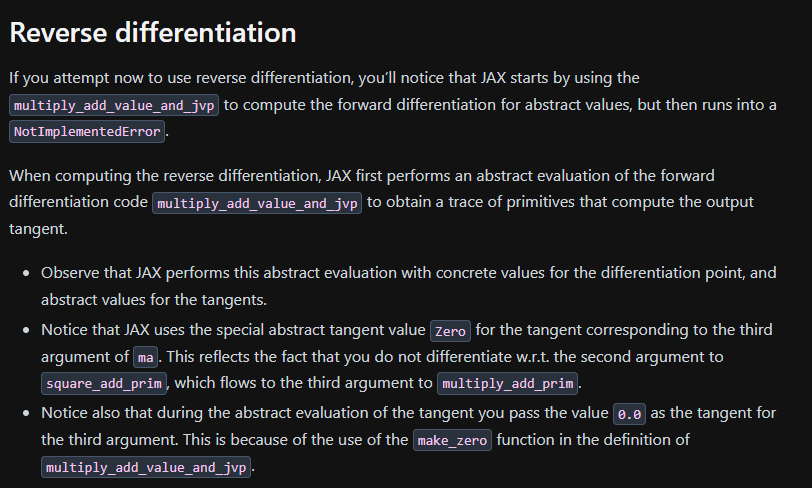

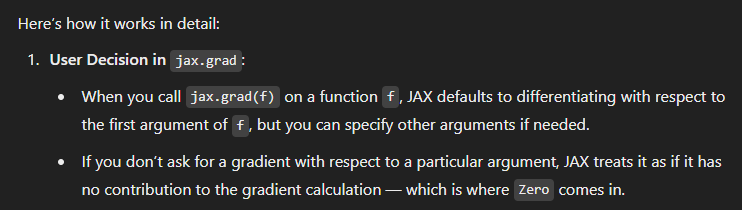

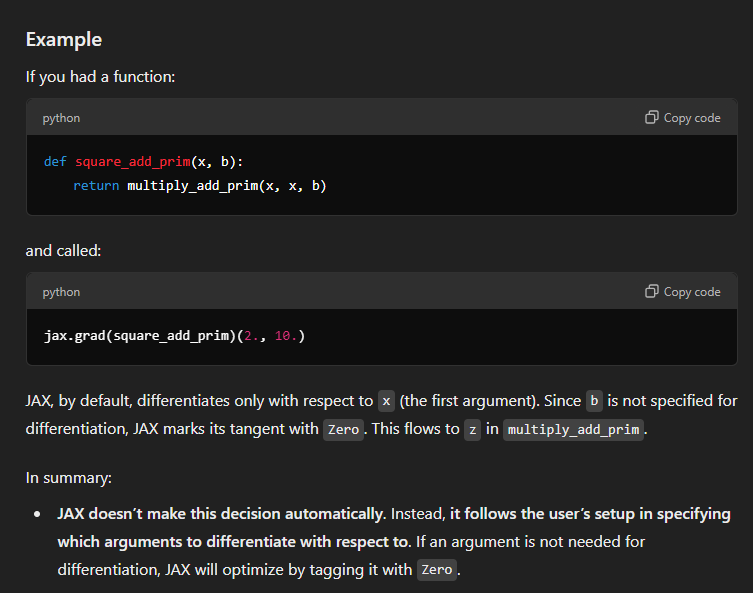

In [19]:
# This is reverse differentiation w.r.t. the first argument of `square_add_prim`
with expectNotImplementedError():
  api.grad(square_add_prim)(2., 10.)

call square_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
  call multiply_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
    call multiply_add_value_and_jvp((2.0, 2.0, 10.0), (Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Zero(ShapedArray(float32[], weak_type=True))))
      Primal evaluation:
      call multiply_add_prim(2.0, 2.0, 10.0)
        call multiply_add_impl(2.0, 2.0, 10.0)
        |<- multiply_add_impl = 14.0
      |<- multiply_add_prim = 14.0
      Tangent evaluation:
      call multiply_add_prim(2.0, Traced<ShapedArray(float32[], weak_type=True)>, 0.0)
        call multiply_add_abstract_eval(ConcreteArray(2.0, dtype=float32, weak_type=True), ShapedArray(float32[], weak_type=True), ConcreteArray(0.0, dtype=float32, weak_type=True))
        |<- multiply_add_abstract_eval = ShapedArray(float32[])
      |<- multiply_

Traceback (most recent call last):
  File "d:\anaconda3\Lib\site-packages\jax\_src\interpreters\ad.py", line 284, in get_primitive_transpose
    return primitive_transposes[p]
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyError: multiply_add

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\haadi\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
jax._src.source_info_util.JaxStackTraceBeforeTransformation: NotImplementedError: Transpose rule (for reverse-mode differentiation) for 'multiply_add' not implemented

The preceding stack trace is the source of the JAX operation that, once transformed by JAX, triggered the following exception.

--------------------

The above exception was the direct cause of the following exception:

Traceback (most recent

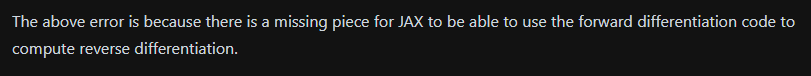

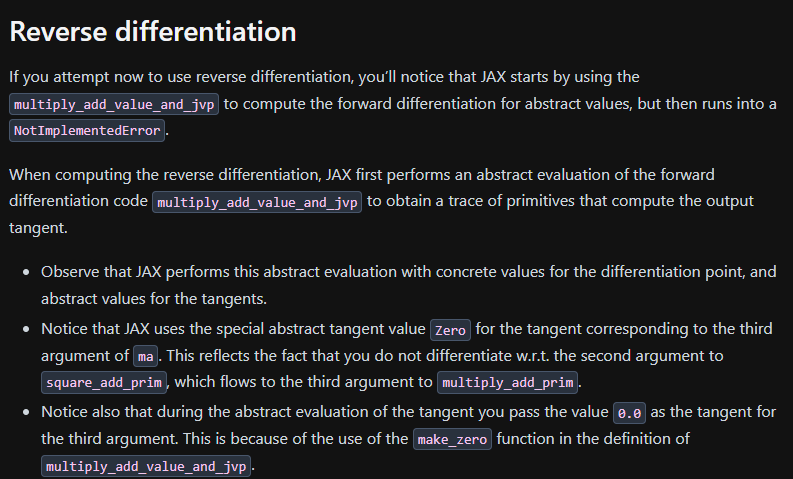

In [20]:
# This is reverse differentiation w.r.t. the first argument of `square_add_prim`
with expectNotImplementedError():
  api.grad(square_add_prim)(2., 10.)

call square_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
  call multiply_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
    call multiply_add_value_and_jvp((2.0, 2.0, 10.0), (Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Zero(ShapedArray(float32[], weak_type=True))))
      Primal evaluation:
      call multiply_add_prim(2.0, 2.0, 10.0)
        call multiply_add_impl(2.0, 2.0, 10.0)
        |<- multiply_add_impl = 14.0
      |<- multiply_add_prim = 14.0
      Tangent evaluation:
      call multiply_add_prim(2.0, Traced<ShapedArray(float32[], weak_type=True)>, 0.0)
        call multiply_add_abstract_eval(ConcreteArray(2.0, dtype=float32, weak_type=True), ShapedArray(float32[], weak_type=True), ConcreteArray(0.0, dtype=float32, weak_type=True))
        |<- multiply_add_abstract_eval = ShapedArray(float32[])
      |<- multiply_

Traceback (most recent call last):
  File "d:\anaconda3\Lib\site-packages\jax\_src\interpreters\ad.py", line 284, in get_primitive_transpose
    return primitive_transposes[p]
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyError: multiply_add

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\haadi\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
jax._src.source_info_util.JaxStackTraceBeforeTransformation: NotImplementedError: Transpose rule (for reverse-mode differentiation) for 'multiply_add' not implemented

The preceding stack trace is the source of the JAX operation that, once transformed by JAX, triggered the following exception.

--------------------

The above exception was the direct cause of the following exception:

Traceback (most recent

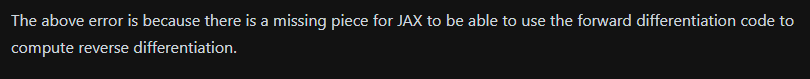

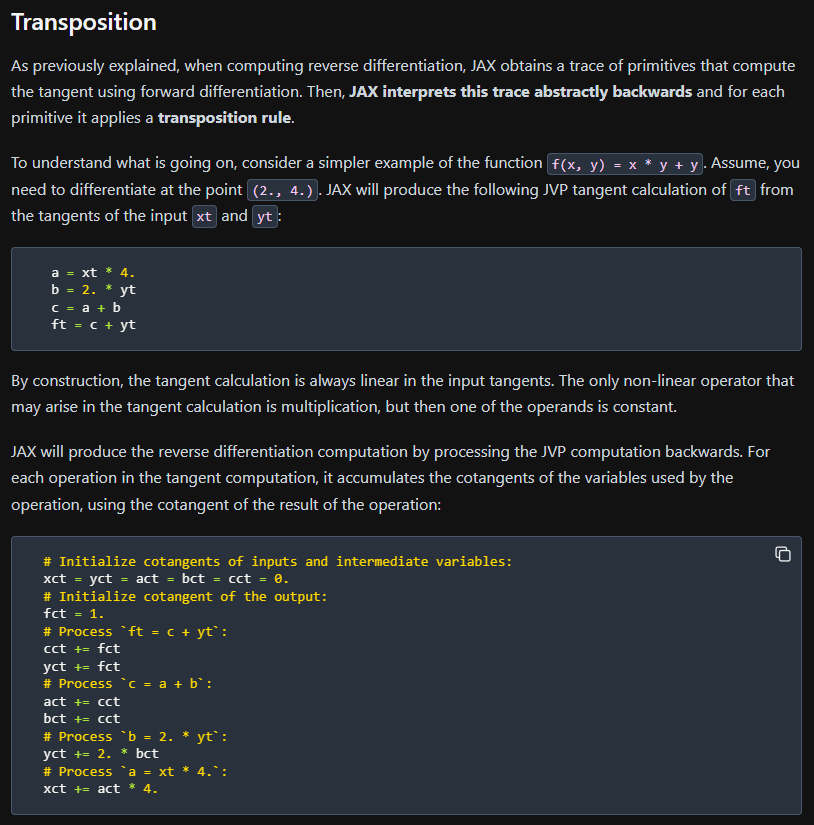
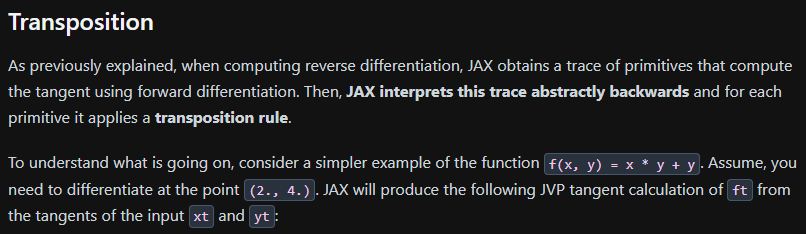

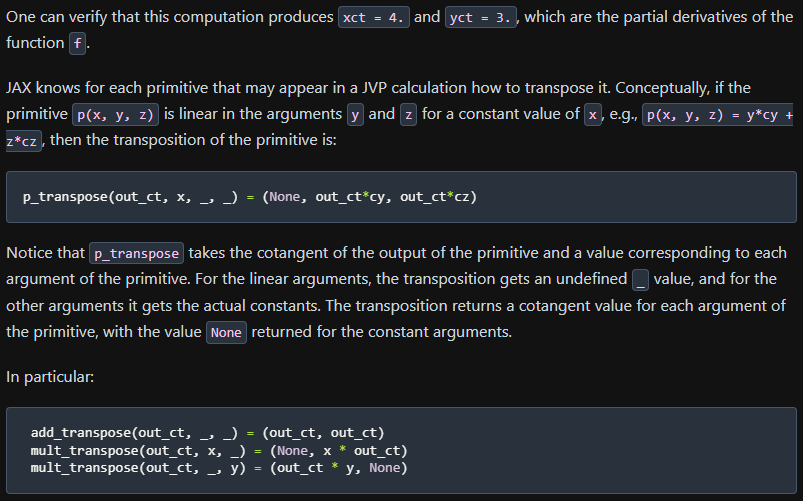
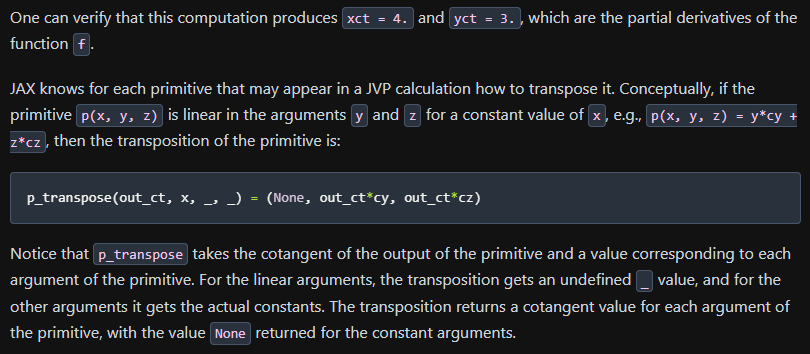

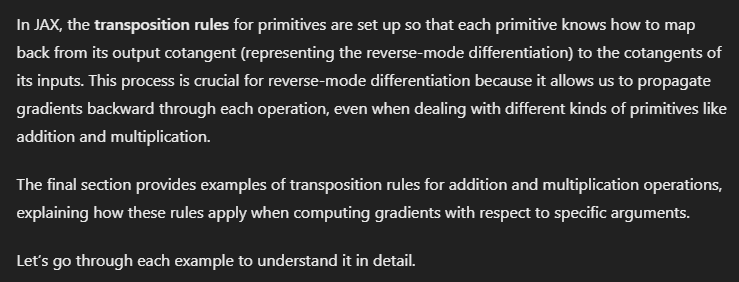

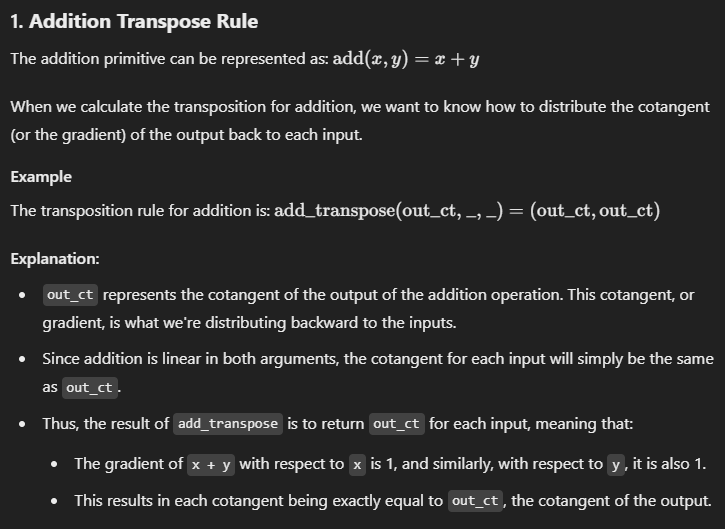

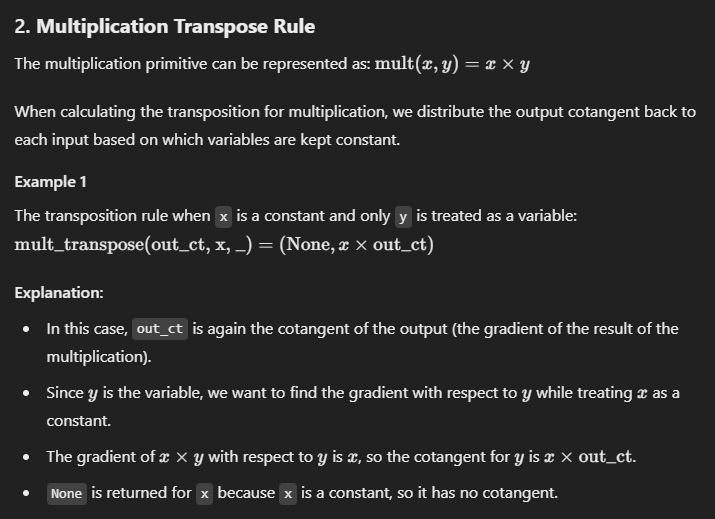

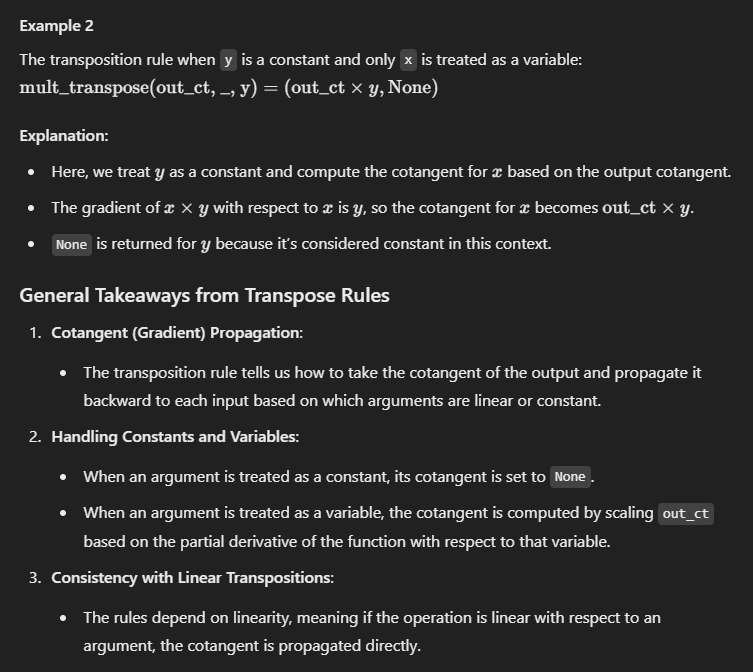

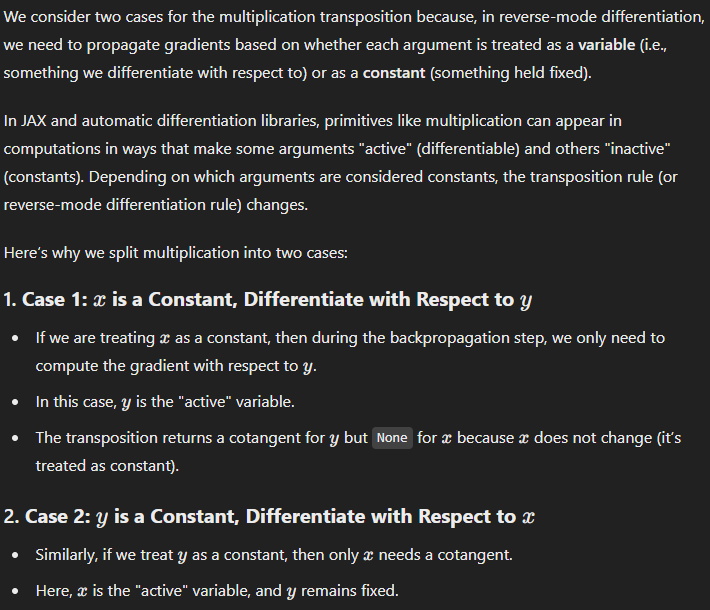

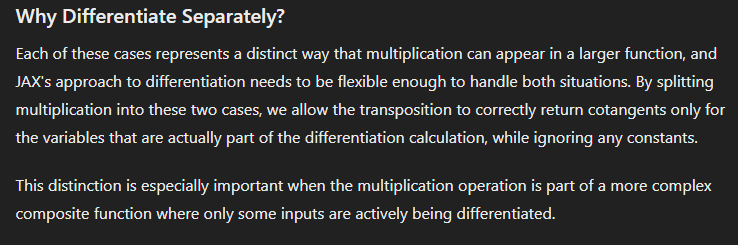

In [21]:
@trace("multiply_add_transpose")
def multiply_add_transpose(ct, x, y, z):
  """Evaluates the transpose of a linear primitive.

  This method is only used when computing the backward gradient following 
  `value_and_jvp`, and is only needed for primitives that are used in the JVP 
  calculation for some other primitive. You need a transposition for `multiply_add_prim`, 
  because you have used `multiply_add_prim` in the computation of the `output_tangent` in 
  `multiply_add_value_and_jvp`.

  In this case, multiply_add is not a linear primitive. However, it is used linearly 
  w.r.t. tangents in `multiply_add_value_and_jvp`:
       `output_tangent(xt, yt, zt) = multiply_add_prim(xt, y, multiply_add_prim(x, yt, zt))`.

  Always one of the first two multiplicative arguments is a constant.

  Args:
      ct: The cotangent of the output of the primitive.
      x, y, z: The values of the arguments. The arguments that are used linearly
        get an ad.UndefinedPrimal value. The other arguments get a constant
        value.

  Returns:
      A tuple with the cotangent of the inputs, with the value None
      corresponding to the constant arguments.
  """
  if not ad.is_undefined_primal(x):
    # This use of multiply_add is with a constant "x".
    assert ad.is_undefined_primal(y)
    ct_y = ad.Zero(y.aval) if type(ct) is ad.Zero else multiply_add_prim(x, ct, lax.zeros_like_array(x))
    res = None, ct_y, ct
  else:
    # This use of multiply_add is with a constant "y".
    assert ad.is_undefined_primal(x)
    ct_x = ad.Zero(x.aval) if type(ct) is ad.Zero else multiply_add_prim(ct, y, lax.zeros_like_array(y))
    res = ct_x, None, ct
  return res

ad.primitive_transposes[multiply_add_p] = multiply_add_transpose

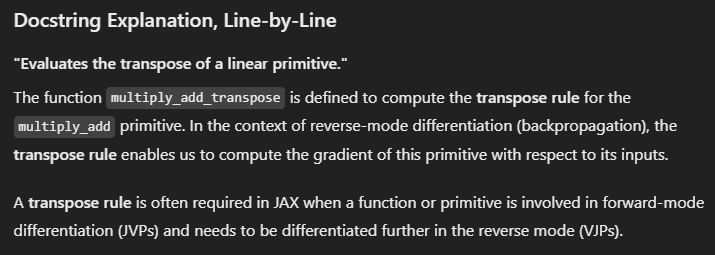

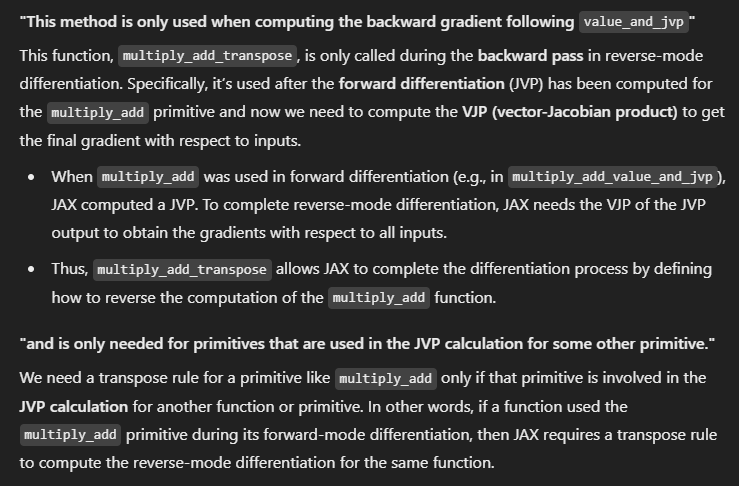

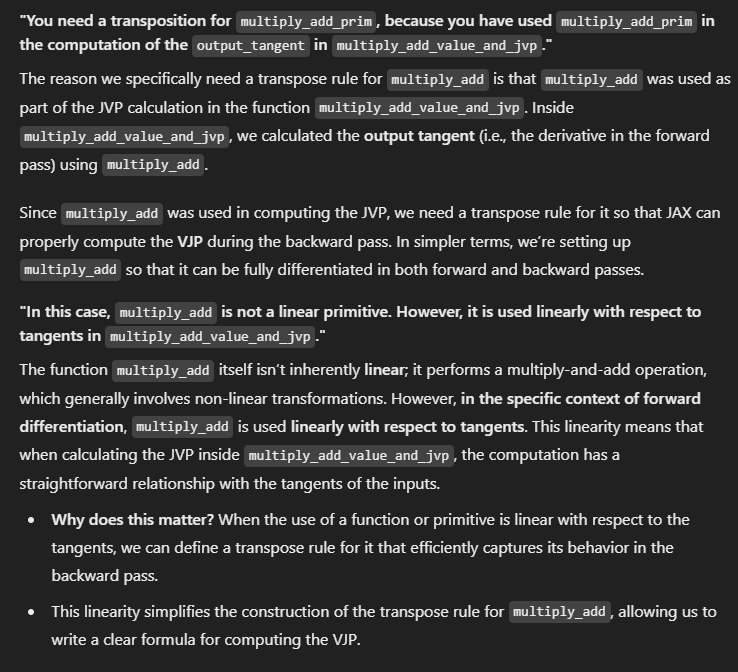

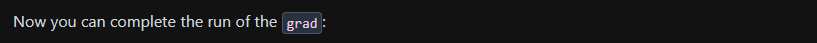

In [22]:
assert api.grad(square_add_prim)(2., 10.) == 4.

call square_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
  call multiply_add_prim(Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, Traced<ConcreteArray(2.0, dtype=float32, weak_type=True)>, 10.0)
    call multiply_add_value_and_jvp((2.0, 2.0, 10.0), (Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Zero(ShapedArray(float32[], weak_type=True))))
      Primal evaluation:
      call multiply_add_prim(2.0, 2.0, 10.0)
        call multiply_add_impl(2.0, 2.0, 10.0)
        |<- multiply_add_impl = 14.0
      |<- multiply_add_prim = 14.0
      Tangent evaluation:
      call multiply_add_prim(2.0, Traced<ShapedArray(float32[], weak_type=True)>, 0.0)
        call multiply_add_abstract_eval(ConcreteArray(2.0, dtype=float32, weak_type=True), ShapedArray(float32[], weak_type=True), ConcreteArray(0.0, dtype=float32, weak_type=True))
        |<- multiply_add_abstract_eval = ShapedArray(float32[])
      |<- multiply_

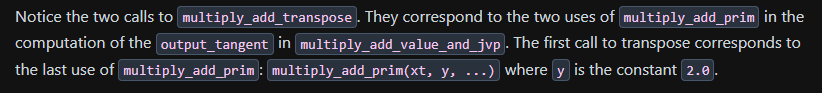

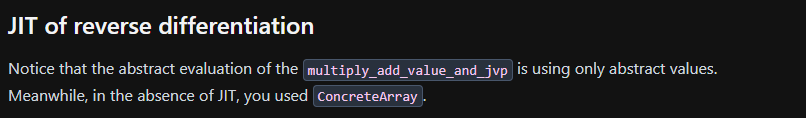

In [23]:
assert api.jit(api.grad(square_add_prim))(2., 10.) == 4.

call square_add_prim(Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
  call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>)
    call multiply_add_value_and_jvp((Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>), (Traced<ShapedArray(float32[], weak_type=True)>, Traced<ShapedArray(float32[], weak_type=True)>, Zero(ShapedArray(float32[], weak_type=True))))
      Primal evaluation:
      call multiply_add_prim(Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, 

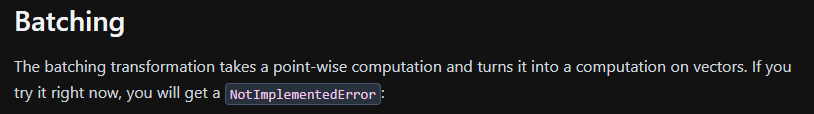

In [24]:
# The arguments are two vectors instead of two scalars.
with expectNotImplementedError():
  api.vmap(square_add_prim, in_axes=0, out_axes=0)(np.array([2., 3.]),
                                               np.array([10., 20.]))

call square_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)
  call multiply_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)

Found expected exception:


Traceback (most recent call last):
  File "C:\Users\haadi\AppData\Local\Temp\ipykernel_23036\1080163607.py", line 3, in <module>
    api.vmap(square_add_prim, in_axes=0, out_axes=0)(np.array([2., 3.]),
  File "d:\anaconda3\Lib\site-packages\jax\_src\traceback_util.py", line 179, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\Lib\site-packages\jax\_src\api.py", line 1214, in vmap_f
    out_flat = batching.batch(
               ^^^^^^^^^^^^^^^
NotImplementedError: Batching rule for 'multiply_add' not implemented


In [25]:
from jax.interpreters import batching

@trace("multiply_add_batch")
def multiply_add_batch(vector_arg_values, batch_axes):
  """Computes the batched version of the primitive.
  
  This must be a JAX-traceable function.
  
  Since the `multiply_add primitive` already operates point-wise on arbitrary
  dimension tensors, to batch it you can use the primitive itself. This works as
  long as both the inputs have the same dimensions and are batched along the
  same axes. The result is batched along the axis that the inputs are batched.

  Args:
    vector_arg_values: A tuple of two arguments, each being a tensor of matching
      shape.
    batch_axes: The axes that are being batched. See vmap documentation.

  Returns:
    A tuple of the result, and the result axis that was batched. 
  """
  assert batch_axes[0] == batch_axes[1]
  assert batch_axes[0] == batch_axes[2]
  _trace("Using multiply_add to compute the batch:")
  res = multiply_add_prim(*vector_arg_values)
  return res, batch_axes[0]


batching.primitive_batchers[multiply_add_p] = multiply_add_batch

In [26]:
assert np.allclose(api.vmap(square_add_prim, in_axes=0, out_axes=0)(
  np.array([2., 3.]),
  np.array([10., 20.])),
  [14., 29.])

call square_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)
  call multiply_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)
    call multiply_add_batch(([2. 3.], [2. 3.], [10. 20.]), (0, 0, 0))
      Using multiply_add to compute the batch:
      call multiply_add_prim([2. 3.], [2. 3.], [10. 20.])
        call multiply_add_impl([2. 3.], [2. 3.], [10. 20.])
        |<- multiply_add_impl = [14. 29.]
      |<- multiply_add_prim = [14. 29.]
    |<- multiply_add_batch = ([14. 29.], 0)
  |<- multiply_add_prim = Traced<ShapedArray(float32[])>
|<- square_add_prim = Traced<ShapedArray(float32[])>


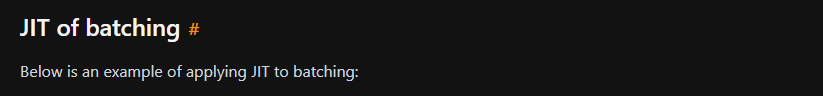

In [27]:
assert np.allclose(api.jit(api.vmap(square_add_prim, in_axes=0, out_axes=0))
                    (np.array([2., 3.]),
                     np.array([10., 20.])),
                    [14., 29.])

call square_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)
  call multiply_add_prim(Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>, Traced<ShapedArray(float32[])>)
    call multiply_add_batch((Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>), (0, 0, 0))
      Using multiply_add to compute the batch:
      call multiply_add_prim(Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>)
        call multiply_add_abstract_eval(ShapedArray(float32[2]), ShapedArray(float32[2]), ShapedArray(float32[2]))
        |<- multiply_add_abstract_eval = ShapedArray(float32[2])
      |<- multiply_add_prim = Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>